In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
import librosa
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
from sklearn.utils import shuffle
tf.random.set_seed(999)
np.random.seed(999)

In [3]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
fs           = 16000
numFeatures  = ffTLength//2 + 1
numSegments  = 8
window = scipy.signal.hamming(windowLength, sym = False)

In [4]:
def read_audio(filepath,sample_rate, normalize= True):
    
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr
        
def add_noise_to_clean_audio(clean_audio, noise_signal):
    
    if len(clean_audio) >= len(noise_signal):
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [5]:
mozilla_basepath = 'en'
UrbanSound8K_basepath = 'UrbanSound8K'

In [6]:
cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'clips', 'common_voice_en_16226.mp3'), sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) 

C:\Users\sreem\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Min: -0.33333334 Max: 0.3112774


In [7]:
noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'audio\\fold1', '101415-3-0-2.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr)

Min: -0.33333334 Max: 0.3144559


In [8]:
stft_features = librosa.stft(noiseAudio, n_fft=ffTLength, win_length=windowLength, hop_length=overlap,
                        window=window, center=True)
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 4.2348603e-08 Max: 17.756714


In [9]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) 

In [10]:
def prepare_input_features(stft_features):
    
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [11]:
noise_stft_features = librosa.stft(noisyAudio, n_fft=ffTLength, win_length=windowLength, hop_length=overlap,
                        window=window, center=True)


noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 1417)


In [12]:
predictors = prepare_input_features(noise_stft_features)

In [13]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (1417, 129, 8, 1)


In [14]:
model = tf.keras.models.load_model("model.h5")

In [15]:
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

(1417, 129, 1, 1)


In [16]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return librosa.istft(features, win_length=windowLength, hop_length=overlap,
                         window=window, center=True)

In [17]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -0.15618895 Max: 0.21771604


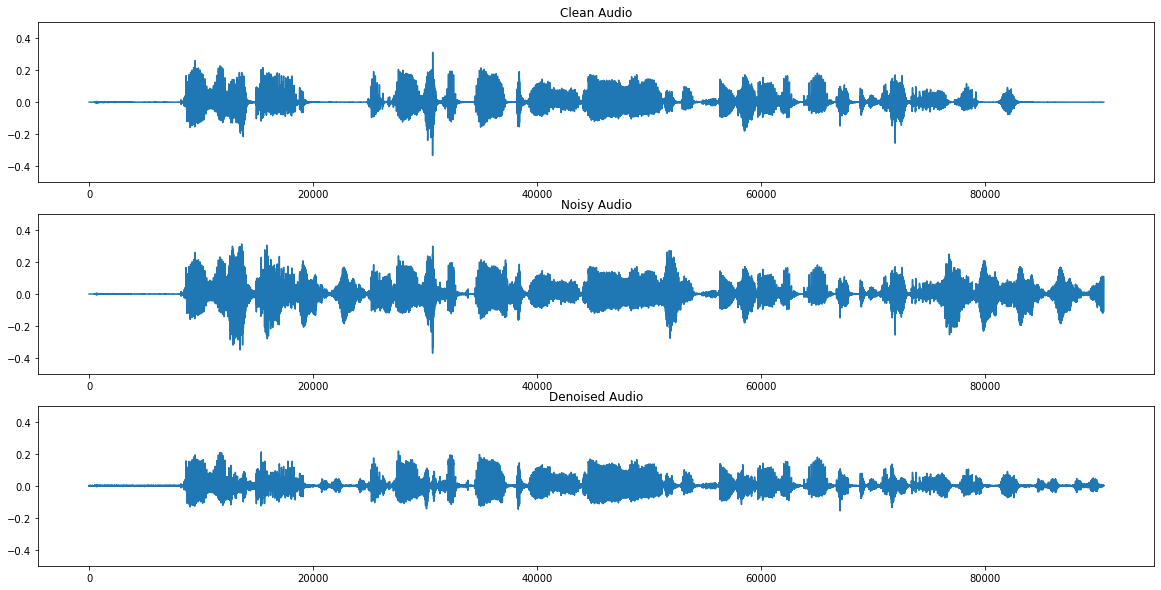

In [18]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(3, 1, 1)
plt.ylim(-0.5, 0.5)
ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)
plt.ylim(-0.5, 0.5)
ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)
plt.ylim(-0.5, 0.5)
ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")

plt.show()